# Exercise 2

In [50]:
import matplotlib.pyplot as plt
import math
import numpy as np

In [51]:
# Initial Conditions

# define step width and global steps
t: int = 200
dt: float = 0.001
N: int = int(t/dt)

# Define Parameters
sigma: int = 10
rho: int = 28
betta: float = 8/3

# define zi_0
x_0: float = -0.587
y_0: float = -0.563
z_0: float = 16.870

zt_0 = np.array([x_0, y_0, z_0])

# Define initial gn
a: float = 1/math.sqrt(dt)
g_00: float = a * ((2 ** (-1/2)) - 1/2)
g_01: float = a * ((3 ** (-1/2)) - 1/2)
g_02: float = a * ((5 ** (-1/2 )) - 1/2)
g_n = np.array([g_00, g_01, g_02])

In [52]:
def tent_map(gn: np.array, a: float) -> float:
    """
    Takes gn with dim=N3 and a as a float.
    it will perform the tent map transformation on error g_n to produce the error for gn + 1
    :param gn: the error state at time n
    :param a: 1/sqrt(dt)
    :return: gn + 1
    """
    # set the values to -2 only if a is gni is outside that range
    i1: np.array = np.array([-1.99999, -1.99999, -1.99999])
    i1[np.where((-a/2 <= gn) & (gn < 0))] = 1.99999

    return (gn * i1) + a/2

In [53]:
def fz(zt: np.array) -> np.array:
    """
    perform f(z) function
    :param zt: current state z
    :return: f(zt)
    """
    # unpack the values x, y, z
    x, y, z = zt

    return np.array([
        sigma * (y - x),
        x * (rho - z) - y,
        (x * y) - (betta * z)
    ])

In [54]:
def forward_euler(zt: np.array, gn: np.array, dt: float) -> np.array:
    """
    Perform the forward euler step
    :param zt: current state
    :param gn: current error
    :param dt: delta t (time step)
    :return: zt +1
    """
    return zt + dt * (fz(zt=zt) + gn)

In [55]:
x_coordinates = [x_0]
y_coordinates = [y_0]
z_coordinates = [z_0]

z_k = zt_0
for i in range(N):
    # update z_k
    z_k = forward_euler(zt=z_k, gn=g_n, dt=dt)

    # update error
    g_n = tent_map(gn=g_n, a=a)

    # append coordinates every step of t
    x, y, z = z_k
    x_coordinates.append(x)
    y_coordinates.append(y)
    z_coordinates.append(z)


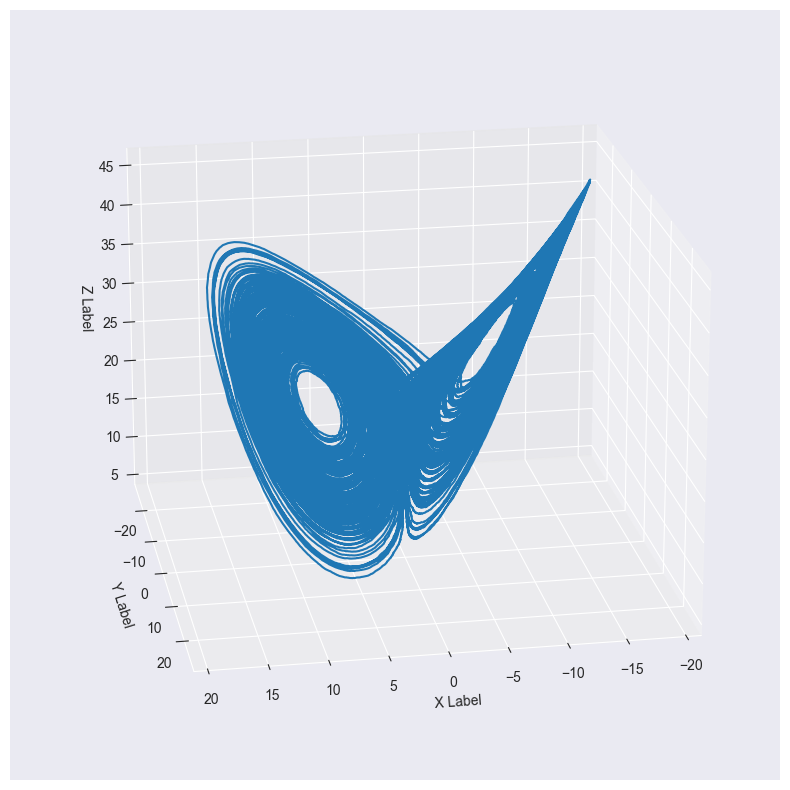

In [57]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.plot(x_coordinates,  y_coordinates, z_coordinates, label="Attention Switched X and Y position")

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(20, 80)


# set labels
plt.show()


# Task 2

In [58]:
# define step width and global steps
t: int = 10
dt: float = 0.001
t_out = 0.05

N: int = int(t/dt)
a = 4
exi_0 = a * ((2 ** (-1/2)) - 1/2)

In [59]:
def modified_tent_map(exi_k: float, a: float):
    # set the values to -2 only if a is gni is outside that range
    temp_factor: float = 1.99999 if (-a/2) <= exi_k < 0 else -1.99999
    return (exi_k * temp_factor) + a/2

In [60]:
def produce_observations(reference_trajectory: list, dt: float, time: int = 10) -> tuple:
    x_errors = [exi_0]
    exi_k = exi_0

    y_observations: list = []
    measurement_errors: list = []

    for _ in range(N):
        # update error
        exi_k = modified_tent_map(exi_k=exi_k, a=a)

        # append error
        x_errors.append(exi_k)

    for i, x_ref in enumerate(reference_trajectory):
        t_curr: float = i * dt  # starting in the small sub steps
        if t_curr == t:
            break

        if i % 50 == 0:
            measurement_error: float = sum(x_errors[int(i/20)*20: (int(i/20)+1) * 20])/20
            y_obs = x_ref + measurement_error
            y_observations.append(y_obs)
            measurement_errors.append(measurement_error)

    return y_observations, measurement_errors

In [61]:
x_observations, measurement_errors = produce_observations(reference_trajectory=x_coordinates, dt=dt, time=t)

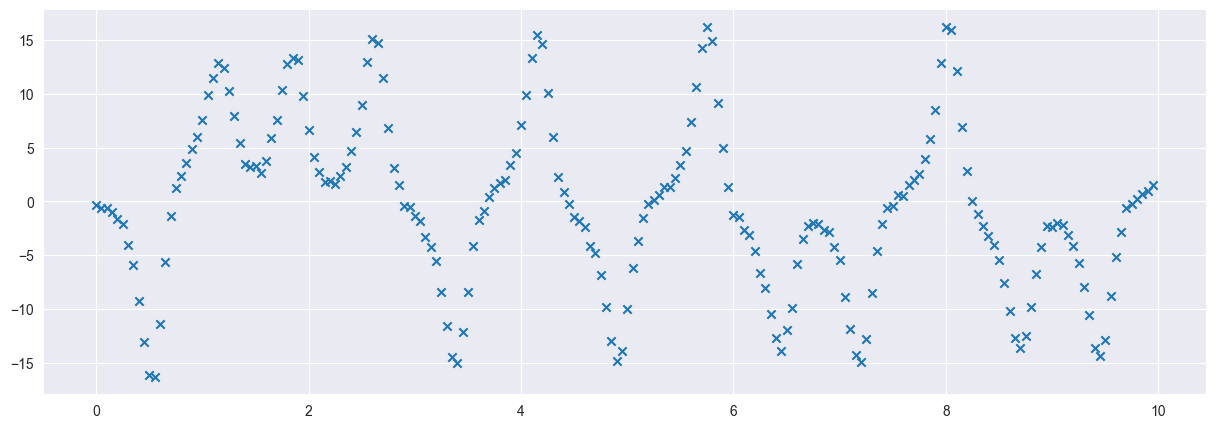

In [62]:
plt.figure(figsize=(15,5))
plt.scatter([i*t_out for i in range(len(x_observations))], x_observations, marker="x")

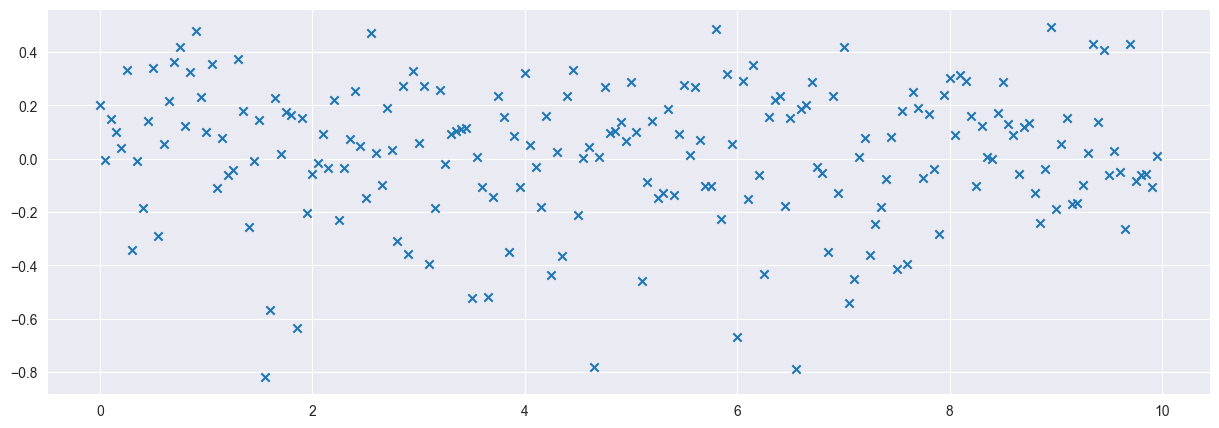

In [63]:
plt.figure(figsize=(15,5))
plt.scatter([i*t_out for i in range(len(measurement_errors))], measurement_errors, marker="x")

# Task 3

In [64]:
t = 200
tk_0 = 100

In [65]:
def time_averaged_rmse(N: int, x_observations: list, x_predictions: list) -> float:
    """
    Calculate the RMSE time averaged
    :param N: Number of samples
    :param y_observations: Observations
    :param y_predictions: Predictions
    :return: time averaged RMSE
    """

    y_obs: np.array = np.array(x_observations)
    y_pred: np.array = np.array(x_predictions)

    return np.sqrt(np.sum(np.absolute(y_pred - y_obs) ** 2)/N)

In [66]:
def qt(x_obs_current: float, x_obs_prev: float) -> float:
    """
    forward step
    :param x_obs_current: y_obs(k*)
    :param x_obs_prev:  y_obs(k*-1)
    :return: y_prediction(k*+1=
    """
    return 2 * x_obs_current - x_obs_prev

In [69]:
x_observations, _ = produce_observations(reference_trajectory=x_coordinates, dt=dt, time=t)

In [70]:
x_predictions: list = []
x_ref_old: float = x_observations[2000]

for i, x_ref_current in enumerate(x_observations[2001:]):
    if i * dt == t:
        break

    x_prediction = qt(x_obs_current=x_ref_current, x_obs_prev=x_ref_old)
    x_predictions.append(x_prediction)

    # move on
    x_ref_old = x_ref_current


In [77]:
# calculate error
N=4000
rmse = time_averaged_rmse(N=N, x_predictions=x_predictions, x_observations=x_observations[2001:])
rmse

1.5055062345804588

Text(0, 0.5, '$x$-component')

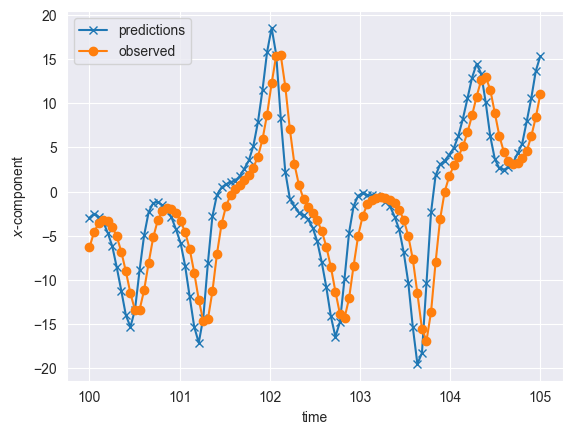

In [71]:
fig1,ax1=plt.subplots()
x1=np.linspace(100,105,100)
ax1.plot(x1,x_predictions[:100], label='predictions', marker='x')
ax1.plot(x1,x_observations[2000:2100], label='observed', marker='o')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('$x$-component')